# Personalised recommendations to increase AOV of Instacart loyalists

---

## Part 3: RFM analysis using K-means clustering

In this notebook, I will be doing RFM analysis of Instacart's customers using K-means clustering, which is an unsupervised machine learning algorithm. Given a value of k, it tries to build k clusters from samples in the dataset.

NOTE: I have reduced the dataset in Part 2, but that will only be used when building the recommendation systems. Clustering will be done using the entire dataset for more meaningful analysis.

---

### Load libraries and datasets

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pickle
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_pickle('../datasets/full_combined_df.pkl')

## RFM analysis

Recency (R), Frequency (F), and Monetary value (M) is a marketing analysis tool used to identify an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

- **Recency**: How recently a customer has made a purchase (time interval between last purchase and current date)
    - The more recent the purchase, the more likely he/she will continue to keep the brand in mind for subsequent purchases. 
    
    
- **Frequency**: How often a customer makes a purchase
    - The more frequently a customer buys, the more loyal, engaged and satisfied he/she is.
    
    
- **Monetary value**: How much money a customer spends on purchases. This can be over the lifetime of the customer, or a timeframe can be self-decided.
    - Monetary value differentiates heavy spenders from low-value purchasers


(Sources: [Investopedia](https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp), [Clevertap](https://clevertap.com/blog/rfm-analysis/))

First, let's take a look at all the data we have.

In [3]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,2539329,1,1,2,8,NaN,196,1,0,Soda,beverages,soft drinks
1,2398795,1,2,3,7,15.0,196,1,1,Soda,beverages,soft drinks
2,473747,1,3,3,12,21.0,196,1,1,Soda,beverages,soft drinks
3,2254736,1,4,4,7,29.0,196,1,1,Soda,beverages,soft drinks
4,431534,1,5,4,15,28.0,196,1,1,Soda,beverages,soft drinks


### Calculate the RFM values for all users

In our dataset, we do not have the order transaction dates and monetary value of orders which are needed to calculate Recency (R) and Monetary (M), so I will use proxy values for these 2 factors.

- **Recency (R)**: Instead of using the time interval between last purchase and current date, I will use the average days between orders as a proxy. This is done by taking the average of days since prior order.

- **Frequency (F)**: Total orders made, calculated by summing up the total number of orders made by each customer.

- **Monetary (M)**: Since we do not have the monetary value of the orders, I will use the average order size of the customer as a proxy, with the assumption that order size has a general positive relationship with order value. 

In [4]:
# monetary: use ORDER SIZE as a proxy for monetary value
# calculate the size of each order
order_size = df.groupby('order_id').agg(order_size=('product_id', 'count')).reset_index()

In [5]:
# append `order_size` column to the main df
df = pd.merge(df, order_size, how='left', on='order_id')

In [6]:
# calculate the RFM values for each user
rfm_df = df.groupby('user_id').agg(
                                  # avg days between orders (RECENCY)
                                  R_avg_days_btw_orders=('days_since_prior_order', 'mean'), 
                                  # total orders made (FREQUENCY)
                                  F_total_orders=('order_id', 'nunique'), 
                                  # avg size of each order (MONETARY)
                                  M_avg_order_size=('order_size', 'mean')
                                  ) 

In [7]:
rfm_df

,R_avg_days_btw_orders,F_total_orders,M_avg_order_size
user_id,,,
1,19.200001,11,7.000000
2,18.009390,15,18.150442
3,11.487180,12,7.886364
4,15.357142,5,4.555556
5,12.314285,5,9.826087
...,...,...,...
206205,14.705882,4,14.960784
206206,4.042705,67,6.670175
206207,14.879397,16,16.390135


In [42]:
rfm_df.to_pickle('../datasets/rfm_df.pkl')

In [ ]:
rfm_df = pd.read_pickle('../datasets/rfm_df.pkl')

### Anything else that we need to do before implementing K-means?

To get good results with K-means, the following conditions should be met:
- Data should not have a skewed distribution 
- Data is standardised (i.e. mean of 0 and standard deviation of 1).

Why? K-means group similar customers together based on their distance from centroids.
The location of each data point on the graph is determined by considering all information associated with the specific customer. If any of the information is not on the same distance scale, K-means might not form meaningful clusters.

#### Check skewness of distribution

<AxesSubplot:xlabel='R_avg_days_btw_orders'>

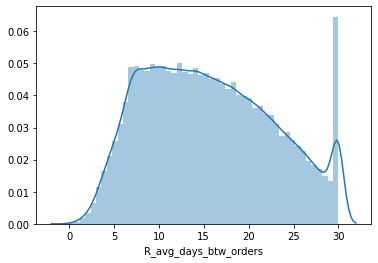

In [8]:
sns.distplot(rfm_df['R_avg_days_btw_orders'].dropna())

<AxesSubplot:xlabel='F_total_orders'>

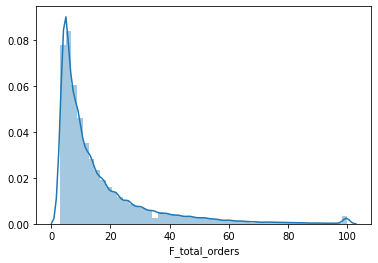

In [9]:
sns.distplot(rfm_df['F_total_orders'])

<AxesSubplot:xlabel='M_avg_order_size'>

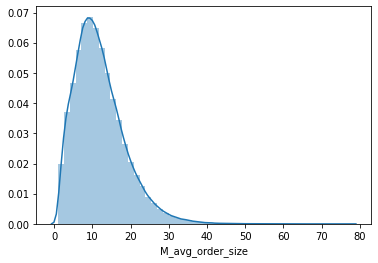

In [10]:
sns.distplot(rfm_df['M_avg_order_size'])

`F_total_orders` and `M_avg_order_size` have a right-tail distribution. We can do a log transformation of these variables to reduce their skewness.

#### Log transformation of F and M variables

In [11]:
rfm_df['M_avg_order_size'] = np.log(rfm_df['M_avg_order_size'])
rfm_df['F_total_orders'] = np.log(rfm_df['F_total_orders'])

#### Re-check distribution after log transformation

<AxesSubplot:xlabel='F_total_orders'>

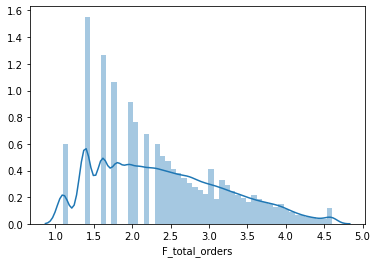

In [12]:
sns.distplot(rfm_df['F_total_orders'])

<AxesSubplot:xlabel='M_avg_order_size'>

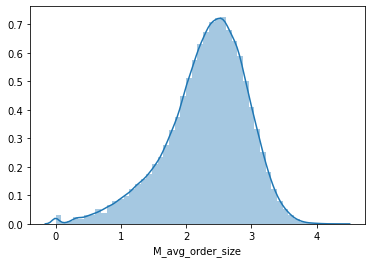

In [13]:
sns.distplot(rfm_df['M_avg_order_size'])

#### Now that skewness is reduced, let's standardise the data

In [14]:
ss = StandardScaler()

In [15]:
rfm_df_scaled = ss.fit_transform(rfm_df)
rfm_df_scaled

array([[ 0.50329327, -0.01399039, -0.58883163],
       [ 0.33538033,  0.35842472,  0.94964918],
       [-0.58445294,  0.09048756, -0.39631663],
       ...,
       [-0.10604538,  0.43591864,  0.78492296],
       [-1.15493349,  1.77982362,  0.74944789],
       [ 0.74350054,  0.27558229,  0.32318817]])

## Implementing K-means clustering

### Select number of clusters _k_ using inertia and silhouette coefficient scores

**Inertia score**

One method for finding the optimal number of clusters for K-means clustering is the "elbow criterion" using inertia scores. How it works:

1. Run k-means clustering on the dataset for a range of values of k, e.g. from 1 to 10. 
2. For each k, calculate the total within-cluster sum of square (WSS), also known as the inertia score.
3. Plot the curve of WSS for each value of k. The total WSS measures intra-cluster variation and we want it to be as small as possible.
4. Locate a bend (elbow) in the plot where the rate at which the WSS decreases levels off. This will be the optimal k number of clusters to use as adding another cluster does not improve WSS by much.

**Silhouette coefficient**

The silhouette coefficient is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.


In [ ]:
# compute the inertia and silhouette scores for k=2 to k=6
scores = []
for k in range(2,7):
    km = KMeans(n_clusters=k)
    km.fit(rfm_df_scaled)
    inertia = km.inertia_
    sil = silhouette_score(rfm_df_scaled, km.labels_) # compute the mean Silhouette Coefficient of all samples
    
    # create a list of lists for the scores
    scores.append([k, inertia, sil])

In [19]:
scores_df = pd.DataFrame(scores, columns=['k', 'inertia', 'silhouette'])
scores_df.head()

,k,inertia,silhouette
0,2,395415.675208,0.320426
1,3,300649.411469,0.310644
2,4,244160.715271,0.278169
3,5,212140.237615,0.270900
4,6,185255.221242,0.277929


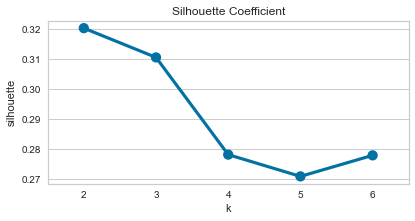

In [59]:
# visualise the silhouette scores
plt.figure(figsize=(6.47,3))
plt.title('Silhouette Coefficient')
sns.pointplot(x=scores_df['k'], y=scores_df['silhouette']);

From the above plot, we can see that the Silhouette Coefficient score drops drastically between k=3 and k=4. This is a good indicator that k=3 is optimal for clustering.

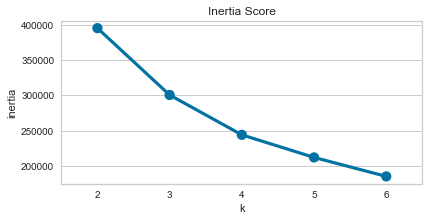

In [58]:
# visualise the inertia (WSS) scores
plt.figure(figsize=(6.47,3))
plt.title('Inertia Score')
sns.pointplot(x=scores_df['k'], y=scores_df['inertia']);

In the above plot, we do not see a very distinguishable "elbow", but we can observe that the decrease in inertia from k=3 to k=4 is about half of that between k=2 and k=3. I will perform clustering with k=3 since the Silhouette Coefficient plot affirms that k=3 is an appropriate number of clusters.

### Perform RFM clustering with k=3

In [23]:
km = KMeans(n_clusters=3, random_state=42)

In [24]:
# fit is all we need to do
km.fit(rfm_df_scaled)

KMeans(n_clusters=3, random_state=42)

In [25]:
km.predict(rfm_df_scaled)

array([0, 2, 1, ..., 1, 1, 2], dtype=int32)

In [26]:
# Check out centroids
km.cluster_centers_

array([[ 0.34847534, -0.53507326, -1.33962692],
       [-0.84620784,  0.96875118,  0.22611882],
       [ 0.60497818, -0.61752113,  0.52569159]])

In [27]:
# attach predicted cluster to rfm df
rfm_df['cluster_k3'] = km.labels_

In [28]:
rfm_df

,R_avg_days_btw_orders,F_total_orders,M_avg_order_size,cluster_k3
user_id,,,,
1,19.200001,2.397895,1.945910,0
2,18.009390,2.708050,2.898695,2
3,11.487180,2.484907,2.065135,1
4,15.357142,1.609438,1.516347,0
5,12.314285,1.609438,2.285041,2
...,...,...,...,...
206205,14.705882,1.386294,2.705432,2
206206,4.042705,4.204693,1.897646,1
206207,14.879397,2.772589,2.796680,1


In [29]:
# take exponential of the two column values that were log-transformed
rfm_df['M_avg_order_size'] = np.exp(rfm_df['M_avg_order_size'])
rfm_df['F_total_orders'] = np.exp(rfm_df['F_total_orders'])

In [30]:
# split dataset into clusters
rfm_df_c1 = rfm_df[rfm_df['cluster_k3'] == 0]
rfm_df_c2 = rfm_df[rfm_df['cluster_k3'] == 1]
rfm_df_c3 = rfm_df[rfm_df['cluster_k3'] == 2]

In [31]:
rfm_df_c3

,R_avg_days_btw_orders,F_total_orders,M_avg_order_size,cluster_k3
user_id,,,,
2,18.009390,15.0,18.150442,2
5,12.314285,5.0,9.826087,2
8,22.173914,4.0,17.298507,2
9,26.117647,4.0,27.857143,2
10,21.007042,6.0,33.925170,2
...,...,...,...,...
206199,18.542772,20.0,19.802292,2
206203,29.209091,6.0,23.212121,2
206204,15.638298,4.0,15.518519,2


In [32]:
c1_temp = pd.DataFrame(rfm_df_c1.mean(), columns=['cluster1_k3'])
c2_temp = pd.DataFrame(rfm_df_c2.mean(), columns=['cluster2_k3'])
c3_temp = pd.DataFrame(rfm_df_c3.mean(), columns=['cluster3_k3'])

# merge the 3 temp cluster dataframes
rfm_df_clusters_mean = pd.merge(c1_temp, c2_temp, left_index=True, right_index=True)
rfm_df_clusters_mean = pd.merge(rfm_df_clusters_mean, c3_temp, left_index=True, right_index=True)
rfm_df_clusters_mean.round(1)

,cluster1_k3,cluster2_k3,cluster3_k3
R_avg_days_btw_orders,18.1,9.6,19.9
F_total_orders,8.4,30.3,7.4
M_avg_order_size,4.8,12.9,15.0
cluster_k3,0.0,1.0,2.0


### Perform RFM clustering with k=4 (for comparison)

In [33]:
km2 = KMeans(n_clusters=4, random_state=42)

In [34]:
# fit is all we need to do
km2.fit(rfm_df_scaled)

KMeans(n_clusters=4, random_state=42)

In [35]:
km2.predict(rfm_df_scaled)

array([2, 1, 1, ..., 1, 3, 0], dtype=int32)

In [36]:
# Check out centroids
km2.cluster_centers_

array([[ 1.1867885 , -0.78582181,  0.33925208],
       [-0.33561382, -0.17620724,  0.4706682 ],
       [ 0.29769288, -0.44479983, -1.5140906 ],
       [-0.98499319,  1.37559708,  0.13703433]])

In [37]:
# attach predicted cluster to rfm df
rfm_df['cluster_k4'] = km2.labels_

In [38]:
km2.labels_

array([2, 1, 1, ..., 1, 3, 0], dtype=int32)

In [39]:
# split dataset into clusters
rfm_df_c1_k4 = rfm_df[rfm_df['cluster_k4'] == 0]
rfm_df_c2_k4 = rfm_df[rfm_df['cluster_k4'] == 1]
rfm_df_c3_k4 = rfm_df[rfm_df['cluster_k4'] == 2]
rfm_df_c4_k4 = rfm_df[rfm_df['cluster_k4'] == 3]

In [40]:
c1_k4_temp = pd.DataFrame(rfm_df_c1_k4.mean(), columns=['cluster1_k4'])
c2_k4_temp = pd.DataFrame(rfm_df_c2_k4.mean(), columns=['cluster2_k4'])
c3_k4_temp = pd.DataFrame(rfm_df_c3_k4.mean(), columns=['cluster3_k4'])
c4_k4_temp = pd.DataFrame(rfm_df_c4_k4.mean(), columns=['cluster4_k4'])

# merge the 3 temp cluster dataframes
rfm_df_clusters_v2_mean = pd.merge(c1_k4_temp, c2_k4_temp, left_index=True, right_index=True)
rfm_df_clusters_v2_mean = pd.merge(rfm_df_clusters_v2_mean, c3_k4_temp, left_index=True, right_index=True)
rfm_df_clusters_v2_mean = pd.merge(rfm_df_clusters_v2_mean, c4_k4_temp, left_index=True, right_index=True)
rfm_df_clusters_v2_mean.round(1)

,cluster1_k4,cluster2_k4,cluster3_k4,cluster4_k4
R_avg_days_btw_orders,24.0,13.3,17.8,8.7
F_total_orders,6.3,10.9,9.1,38.9
M_avg_order_size,13.6,14.6,4.3,12.3
cluster_k3,1.8,1.5,0.0,1.0
cluster_k4,0.0,1.0,2.0,3.0


### Visualise goodness of cluster separation using T-SNE

In [43]:
# Initialise TSNE
tsne = TSNE(n_components=2, random_state=42)
rfm_df_scaled_transformed = tsne.fit_transform(rfm_df_scaled)

<AxesSubplot:title={'center':'Flattened Graph of 3 Clusters'}>

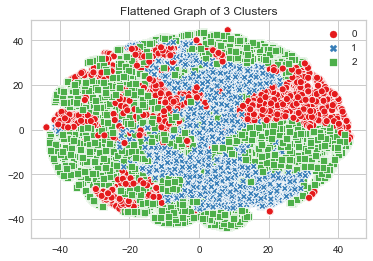

In [44]:
# Plot t-SNE of k=3
plt.title('Flattened Graph of 3 Clusters')
sns.scatterplot(x=rfm_df_scaled_transformed[:,0], y=rfm_df_scaled_transformed[:,1], 
                hue=km.labels_, style=km.labels_, palette="Set1")

<AxesSubplot:title={'center':'Flattened Graph of 4 Clusters'}>

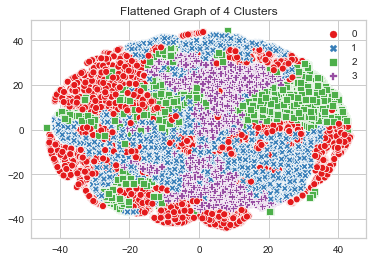

In [45]:
# Plot t-SNE of k=4
plt.title('Flattened Graph of 4 Clusters')
sns.scatterplot(x=rfm_df_scaled_transformed[:,0], y=rfm_df_scaled_transformed[:,1], 
                hue=km2.labels_, style=km2.labels_, palette="Set1")

### RFM visualisation of customer segments

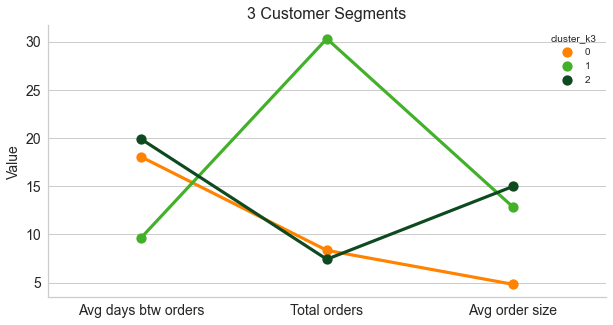

In [111]:
# prepare data for visualisation
rfm_df_k3_melt = pd.melt(rfm_df.drop(columns=['cluster_k4']).reset_index(),
                         id_vars=['user_id', 'cluster_k3'],
                         value_vars=['R_avg_days_btw_orders', 'F_total_orders', 'M_avg_order_size'],
                         var_name='metric',
                         value_name='value',
                         )

# graph plotting
# palette = orange, light green, dark green
palette = ['#ff8200', '#43B02A', '#0E491F']
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.pointplot(x='metric', y='value', data=rfm_df_k3_melt, hue='cluster_k3', palette=palette)
ax.set_xlabel(None)
ax.set_ylabel('Value', fontsize=14)
ax.set_xticklabels(['Avg days btw orders', 'Total orders', 'Avg order size'])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('3 Customer Segments', fontsize=16)
sns.despine(ax=ax);

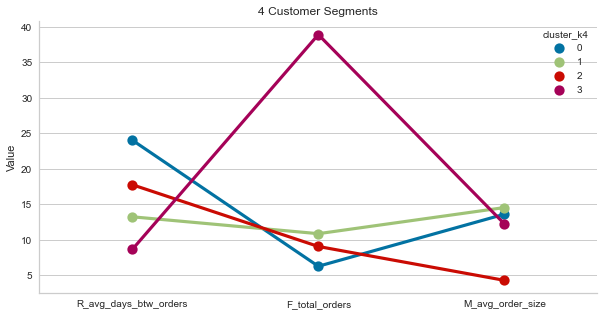

In [112]:
# prepare data for visualisation
rfm_df_k4_melt = pd.melt(rfm_df.drop(columns=['cluster_k3']).reset_index(),
                         id_vars=['user_id', 'cluster_k4'],
                         value_vars=['R_avg_days_btw_orders', 'F_total_orders', 'M_avg_order_size'],
                         var_name='metric',
                         value_name='value')

# graph plotting
plt.figure(figsize=(10,5))
sns.pointplot(x='metric', y='value', data=rfm_df_k4_melt, hue='cluster_k4')
plt.xlabel('')
labels = ['Avg days between orders (R)', 'Total orders (F)', 'Avg order size (M)']
plt.ylabel('Value')
# plt.yticks()
plt.title('4 Customer Segments')
sns.despine()

**Observation from clustering**

- Clustering at k=3 produces more clearly separated clusters and thus that will be our optimal number of clusters.

Now let's analyse the customer segments at k=3 in more detail.

### Size of each segment at k=3

In [51]:
# prepare data for visualisation
cust_count_k3 = pd.DataFrame(rfm_df.groupby('cluster_k3').agg(count=('cluster_k3', 'size'))).reset_index()
cust_count_k3.cluster_k3 = cust_count_k3.cluster_k3.astype(str)

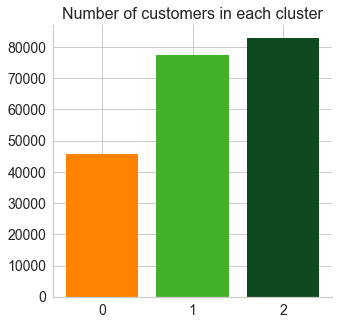

In [105]:
# palette = orange, light green, dark green
palette = ['#ff8200', '#43B02A', '#0E491F']
fig, ax = plt.subplots(figsize=(5,5))
# ax = sns.barplot(cust_count_k3['cluster_k3'], cust_count_k3['count'], palette=palette)
ax.bar(cust_count_k3['cluster_k3'], cust_count_k3['count'], width=0.8, color=palette)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.set_tick_params(labelrotation=0, labelsize=14)
ax.set_title('Number of customers in each cluster', fontsize=16)
sns.despine();

### Characteristics of customer segments at k=3

In [113]:
# re-displaying summary stats of the clusters for analysis
rfm_df_clusters_mean.round(1)

,cluster1_k3,cluster2_k3,cluster3_k3
R_avg_days_btw_orders,18.1,9.6,19.9
F_total_orders,8.4,30.3,7.4
M_avg_order_size,4.8,12.9,15.0
cluster_k3,0.0,1.0,2.0


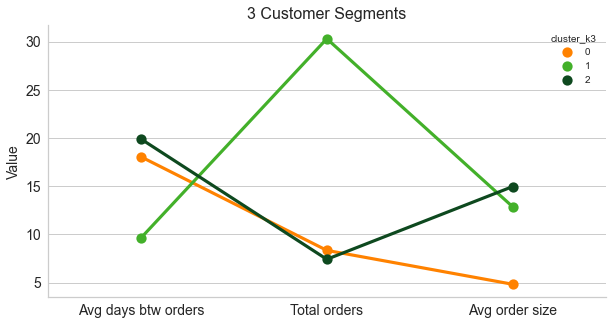

In [114]:
# re-displaying RFM graph
# palette = orange, light green, dark green
palette = ['#ff8200', '#43B02A', '#0E491F']
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.pointplot(x='metric', y='value', data=rfm_df_k3_melt, hue='cluster_k3', palette=palette)
ax.set_xlabel(None)
ax.set_ylabel('Value', fontsize=14)
ax.set_xticklabels(['Avg days btw orders', 'Total orders', 'Avg order size'])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('3 Customer Segments', fontsize=16)
sns.despine(ax=ax);

**Segment 1 (orange): Infrequent customers with no brand loyalty**

- These customers made 8 orders in total, and ordered once every 18 days on average.
- Their order sizes are the smallest at an average of 5 items per order.
- These customers do not have brand loyalty to Instacart and likely have other means of purchasing groceries, e.g. doing their own grocery shopping in-store, using other grocery delivery services like Amazon Fresh, ordering from iHerb, etc. 

**Segment 2 (light green): Instacart's best customers**

- This group forms the loyal customer base at Instacart. 
- They made an average of 30 orders per in total, which is more than twice that of the other two segments.
- They made an order once every 10 days on average and the average order size is about 13 items.
- BUSINESS OPPORTUNITY: Increase their average order size through tailored product recommendations.

**Segment 3 (dark green): Relatively heavy buyers with infrequent purchase cycles**

- This group of customers have on average the highest number of days between purchases and the least amount of total orders.
- However, they have the biggest order sizes, which suggest that these customers tend to buy in bulk and only re-order when their supplies run out. 
- Considering their long purchase cycles, the items they purchase are likely not fresh produce.
- It is likely that these customers also have additional avenues for getting groceries, e.g. they may prefer selecting and purchasing fresh produce personally in stores.